# Data analysis

In [105]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pytz
import pandas as pd

try:
    sc = SparkContext('local[*]')
    sc.setLogLevel("OFF")
    
except ValueError:
    # Prevent the notebook to crash if this block is executed more then once
    pass

spark = SparkSession(sc)

In [2]:
wifi   = spark.read.parquet("./data/ds/wifi-log.parquet")
gps    = spark.read.parquet("./data/ds/gps-log.parquet")
oui    = spark.read.parquet("./data/ds/oui.parquet")
survey = spark.read.parquet("./data/ds/survey.parquet")

In [3]:
survey.groupBy("date").count().withColumn("day", date_format("date", "EEEE")).toPandas()

,date,count,day
0,2017-12-08,46,Friday
1,2017-12-06,46,Wednesday
2,2017-12-13,33,Wednesday
3,2017-11-29,38,Wednesday
4,2017-12-07,43,Thursday
5,2017-12-11,36,Monday
6,2017-12-12,36,Tuesday


In [4]:
phones = wifi.join(oui.dropDuplicates(["prefix"]), substring("mac", 0, 8) == col("prefix"))
makers = phones.groupBy("maker").count().orderBy(desc("count"))

wifi_total = wifi.count()
phones_total = phones.count()

totals = spark.createDataFrame([
    ("Celulares", phones_total, "%.2f%%" % (phones_total / wifi_total * 100)),
    ("Total",  wifi_total, "100%")
], ["", "count", "P"])
totals.toPandas()

,,count,P
0,Celulares,721846,79.57%
1,Total,907168,100%


In [5]:
to_percentage = lambda col_name, total: format_string("%.2f%%", col(col_name) / total * 100)

makers = makers.withColumn("share", to_percentage("count", phones_total))
makers.toPandas().head()

,maker,count,share
0,Samsung,258449,35.80%
1,Motorola,201424,27.90%
2,Lenovo,155135,21.49%
3,LG,47524,6.58%
4,Apple,27201,3.77%


In [6]:
from operator import add

OTHERS_THRESHOLD = 7000

count = makers.filter(col("count") < OTHERS_THRESHOLD).rdd.map(lambda x: x["count"]).reduce(add)
share = "%.2f%%" % (count / phones_total * 100)

others = spark.createDataFrame([("Outros", count, share)], ["maker", "count", "share"])
others.toPandas()

,maker,count,share
0,Outros,9125,1.26%


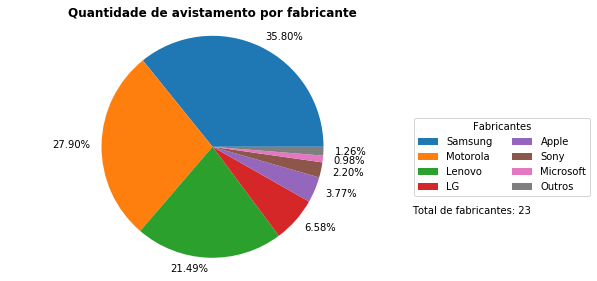

In [7]:
m = makers.filter(col("count") > OTHERS_THRESHOLD).unionAll(others).toPandas()

# 'tab20', 'tab20b', 'tab20c'
# patches.set_cmap("tab20b")

patches, texts = plt.pie(m['count'], labels=m['share'], startangle=0)
plt.title("Quantidade de avistamento por fabricante", {'fontweight':'bold'})
plt.text(1.8, -0.6, "Total de fabricantes: %d" % makers.count())
plt.legend(patches, m['maker'], ncol=2, loc=(1, 0.3), title="Fabricantes")
plt.axis('equal')
plt.tight_layout()

In [8]:
phones_ds = (
    phones
    .withColumn("date", date_format("timestamp", "dd/MM/yyyy"))
    .withColumn("timestamp", to_utc_timestamp(regexp_replace("timestamp", ",", "."), "UTC"))
    .drop("level", "organization", "prefix")
)
phones_ds.groupBy("date").count().withColumn("day", date_format("date", "EEEE")).orderBy("date").toPandas()

,date,count,day
0,06/12/2017,130846,None
1,07/12/2017,77263,None
2,08/12/2017,156245,None
3,11/12/2017,79781,None
4,12/12/2017,165903,None
5,13/12/2017,9798,None
6,29/11/2017,102010,None


In [9]:
mins = lambda i: i * (60*60)

IS_PASSENGER_THRESHOLD = 2

sightings_within_5sec = (
    Window.partitionBy("mac")
    .orderBy(col("timestamp").cast("long"))
    .rangeBetween(0, 5)
)

sightings = (
    phones_ds
    # 1) Unique MAC sightings within 5 seconds
    .withColumn("fst_sight", first("timestamp").over(sightings_within_5sec))
    .filter(col("fst_sight") == col("timestamp"))
    .drop("fst_sight")
    # 2) Group sightings in a sliding windown of 5 minutes each minute
    .groupBy(window("timestamp", "3 minutes", "1 minute"))
    .agg(collect_list("mac").alias("addresses"))
    .orderBy("window")
    # 3) Filter adresses only sighted few times within the window
    .select("window", explode("addresses").alias("mac"))
    .groupBy("window", "mac").count()
    .filter(col("count") > IS_PASSENGER_THRESHOLD)
    .drop("count")
    # 4) Estimate the occupation
    .groupBy("window").count()
    .withColumn("date", date_format("window.start", "dd/MM/yyyy"))
)

# Summary
(
    sightings
    .withColumn("day", date_format("window.start", "EEEE"))
    .groupBy("date").agg(first("day").alias("day"), sum("count"))
    .toPandas()
)

,date,day,sum(count)
0,12/12/2017,Tuesday,31415
1,08/12/2017,Friday,28277
2,06/12/2017,Wednesday,23144
3,11/12/2017,Monday,14987
4,29/11/2017,Wednesday,18105
5,07/12/2017,Thursday,9797
6,13/12/2017,Wednesday,2488


## Escala de classificação da ocupação de um veículo.

|   | Descrição | Definição |
|---|-----------|-----------|
| 1 | Parcialmente sentados | Alguns lugares vazios |
| 2 | Sentados | Todos os bancos ocupados |
| 3 | 25% de ocupação | Todos os bancos ocupados com algumas pessoas em pé |
| 4 | 50% de ocupação | Meia lotação do corredor |
| 5 | 75% de ocupação | Lotação de 3/4 do veículo |
| 6 | 90% de ocupação | Apesar de lotado, observa-se que tem capacidade para atender mais usuários |
| 7 | Lotado | Capacidade total utilizada |
| 8 | Superlotado | Além da capacidade normal |

In [10]:
MAX_OCCUPATION = (58 + 118) * 1.2

def relativeOccupation(sightings):
    if sightings < 30:
        return 1
    elif sightings >= 30 and sightings <= 58:
        return 2
    elif sightings >= 58 and sightings < 87:
        return 3
    elif sightings >= 87 and sightings < 117:
        return 4
    elif sightings >= 117 and sightings < 146:
        return 5
    elif sightings >= 146 and sightings < 164:
        return 6
    elif sightings >= 164 and sightings < MAX_OCCUPATION:
        return 7
    else:
        return 8

occ = udf(lambda x: relativeOccupation(x), IntegerType())

occupation = sightings.withColumn("occupation", occ("count"))    

(
    occupation
    .withColumn("day", date_format("window.start", "EEEE"))
    .withColumn("date", date_format("window.start", "dd/MM/yyyy"))
    .groupBy("date")
    .agg(
        first("day").alias("day"), 
        date_format(first("window.start"), "HH:mm:ss").alias("start"), 
        date_format(last("window.end"), "HH:mm:ss").alias("end"),
        avg("occupation")
    )
    .orderBy("date")
).toPandas()

,date,day,start,end,avg(occupation)
0,06/12/2017,Wednesday,18:49:00,21:26:00,5.303226
1,07/12/2017,Thursday,07:50:00,09:39:00,3.616822
2,08/12/2017,Friday,19:57:00,22:24:00,6.241379
3,11/12/2017,Monday,08:16:00,10:21:00,4.585366
4,12/12/2017,Tuesday,17:25:00,21:41:00,4.484252
5,13/12/2017,Wednesday,14:33:00,14:59:00,4.166667
6,29/11/2017,Wednesday,05:45:00,09:48:00,3.037344


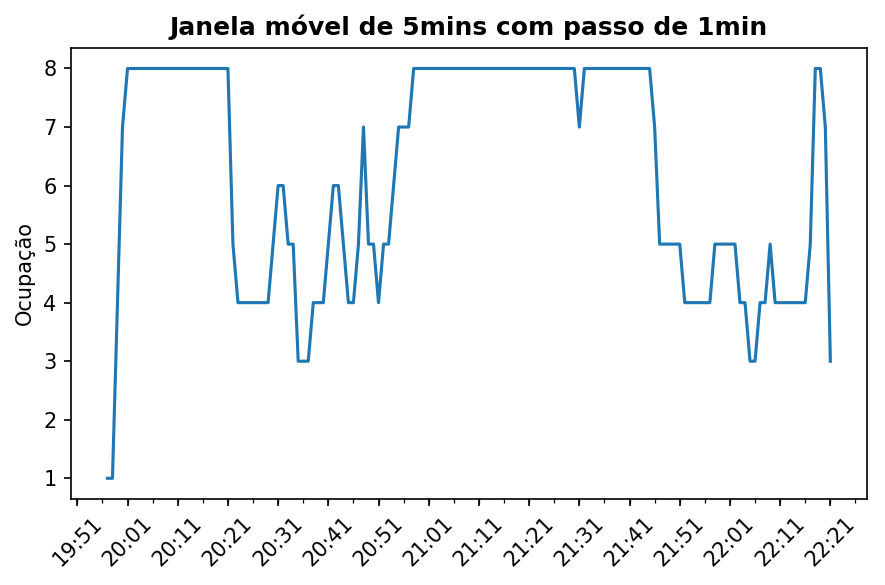

In [11]:
r = occupation.filter(col("date") == "08/12/2017").toPandas()
r['start'] = r["window"].map(lambda x: x[0])
r = r.set_index('start')

x = np.arange(len(r)) # r["window"].map(lambda x: x[0]).values

fig, ax = plt.subplots(dpi=150) # figsize=(15, 10)
ax.plot(r.index, r['occupation'])

ax.set_ylabel("Ocupação")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.title("Janela móvel de 5mins com passo de 1min", {'fontweight': 'demi'})
plt.xticks(rotation=45)
plt.tight_layout()

In [302]:
second_trip = survey.filter(col("occupation") == 8).select("date", col("timestamp").alias("break"))

second_trip.toPandas().set_index("date")

,break
date,
2017-12-13,2017-12-13 13:55:45.350
2017-12-12,2017-12-12 20:16:32.830
2017-12-11,2017-12-11 09:19:00.717
2017-12-08,2017-12-08 20:36:14.032
2017-12-07,2017-12-07 08:40:05.470
2017-12-06,2017-12-06 20:02:27.572
2017-11-29,2017-11-29 08:45:58.703


In [313]:
%%javascript
// Disable output scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

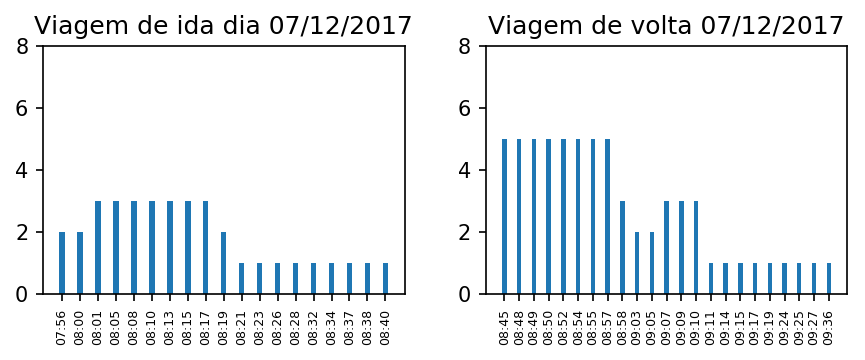

In [312]:
# dates = survey.select("date").distinct()
dates = ["2017-11-29","2017-12-06","2017-12-07","2017-12-08","2017-12-11","2017-12-12","2017-12-13"]

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(6, 2.5))
axes = ax.flatten()


from matplotlib.text import Text

# for i, date in enumerate(dates):
sub = (
    survey.filter(col("date") == "2017-12-07")
    .orderBy("timestamp")
)

# 
a = sub.filter(col("timestamp") < "2017-12-07 08:40:05.400").toPandas()
b = sub.filter(col("timestamp") > "2017-12-07 08:40:05.470").toPandas()

a.set_index(pd.DatetimeIndex(a.timestamp, tz=pytz.utc), inplace=True, verify_integrity=True)
b.set_index(pd.DatetimeIndex(b.timestamp, tz=pytz.utc), inplace=True, verify_integrity=True)

xA = np.arange(len(a))
xB = np.arange(len(b))

labels_kwargs = {'fontdict':{'fontsize': 6}, 'rotation': 90}

axes[0].set_title("Viagem de ida dia %s" % "07/12/2017")
axes[0].bar(xA, a.occupation.values, width=0.3)
axes[0].axes.set_ybound(0, 8)
axes[0].axes.set_xticks(xA)
axes[0].axes.set_xticklabels(a.index.map(lambda x: x.strftime("%H:%M")), **labels_kwargs)

axes[1].set_title("Viagem de volta %s" % "07/12/2017")
axes[1].bar(xB, b.occupation, width=0.3)
axes[1].axes.set_ybound(0, 8)
axes[1].axes.set_xticks(xB)
axes[1].axes.set_xticklabels(b.index.map(lambda x: x.strftime("%H:%M")), **labels_kwargs)

fig.tight_layout()
plt.show()